## Random forest

0. The recall of class 0 (no loss) should be at least 80% and then choose the one with highest recall in class 1 (loss).
1. Three methods: original random forest with SMOTE, balanced random forest with weight and without weight.
2. The best one is balanced random forest without weight trained on original dataset(70% for loss and no loss).
3. Tuning it by changing window size (features), random search and so on.
4. Perform deeper analysis for entire dataset and check behaviours for correct classification and miss-classification (the entire dataset may not be good, I may need to remove certain flows and check the behaviours on them). This is step should be included in later stage.

<!-- 1. choose two methods, one is balanced random forest with original dataset and the other one is original random forest with combination of undersampling and oversampling.
2. check the behaviour for different window size and the results are similar.
- The following are confusing
3. original random forest is better (both for training dataset and entire dataset). it is overfitting ? 
3. balanced rf is not overfitting ?
4. perform deeper analysis for entire dataset and check behaviours for correct classification and miss-classification. (this step is done with balanced rf, I need to do it with original rf later on). This is step should be included in later stage. -->

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import pickle
from sklearn.utils.class_weight import compute_class_weight
from pprint import pprint

warnings.filterwarnings('ignore')

In [2]:
complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [3]:
# load the entire dataset

df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')

In [4]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,interarrival_std_minus_3500ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [5]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

In [6]:
# do not need to consider sampling since in random forest, it's allowed to set class weight

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [7]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [8]:
weight = int(y_train[y_train['lossOrNot']==0].count() / y_train[y_train['lossOrNot']==1].count())
weight

70

In [18]:
classes=[0,1]
class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_train['lossOrNot'])
class_weight

array([ 0.50704983, 35.96183651])

In [20]:
# train with random forest wtih original sklearn

rf = RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0, class_weight={0:class_weight[0], 1:class_weight[1]}) # or class_weight={0:1, 1:weight}
# rf = RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0, class_weight='balanced')

In [21]:
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.5070498322879748,
                                     1: 35.961836507293356},
                       n_estimators=400, n_jobs=48, random_state=0)

Prediction Report
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    600134
           1       0.69      0.02      0.04      8461

    accuracy                           0.99    608595
   macro avg       0.84      0.51      0.51    608595
weighted avg       0.98      0.99      0.98    608595



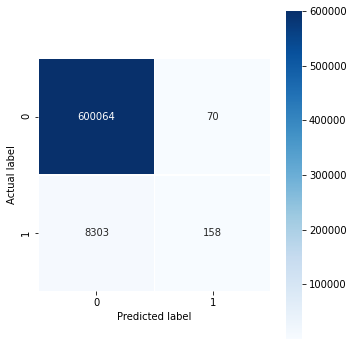

In [22]:
y_pred = rf.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [23]:
# try with imblearn

brf_with_weight = BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0, class_weight={0:1, 1:weight})
# brf_with_weight = BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0, class_weight='balanced')
brf_without_weight = BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0) 

In [24]:
brf_with_weight.fit(x_train, y_train)

BalancedRandomForestClassifier(class_weight='balanced', n_estimators=400,
                               n_jobs=48, random_state=0)

In [117]:
# with open('models/balanced_random_forest_with_weight.pickle', 'wb') as f:
#     pickle.dump(brf_with_weight, f)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.85      0.92   1400317
           1       0.09      1.00      0.16     19744

    accuracy                           0.86   1420061
   macro avg       0.54      0.93      0.54   1420061
weighted avg       0.99      0.86      0.91   1420061



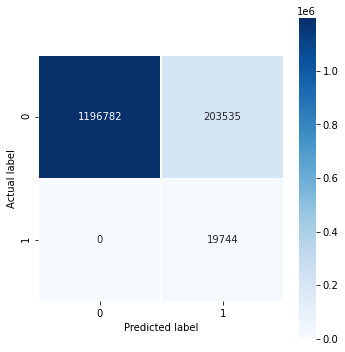

In [96]:
y_pred = brf_with_weight.predict(x_train)
print("Prediction Report\n", classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.64      0.11      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.91    608595



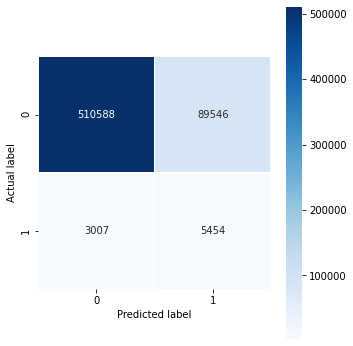

In [97]:
y_pred = brf_with_weight.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [98]:
brf_without_weight.fit(x_train, y_train)

BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.90   1400317
           1       0.07      1.00      0.13     19744

    accuracy                           0.82   1420061
   macro avg       0.54      0.91      0.52   1420061
weighted avg       0.99      0.82      0.89   1420061



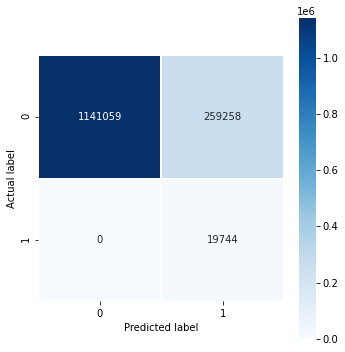

In [99]:
y_pred = brf_without_weight.predict(x_train)
print("Prediction Report\n", classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.06      0.79      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



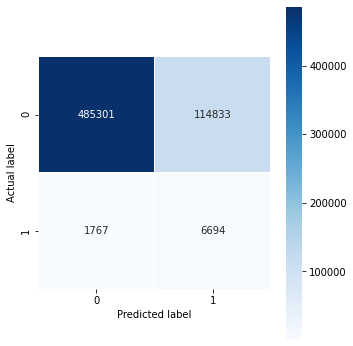

In [100]:
y_pred = brf_without_weight.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## feature selection based on window size

Prediction Report with features of past 500ms
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    600134
           1       0.05      0.70      0.10      8461

    accuracy                           0.83    608595
   macro avg       0.52      0.76      0.50    608595
weighted avg       0.98      0.83      0.89    608595



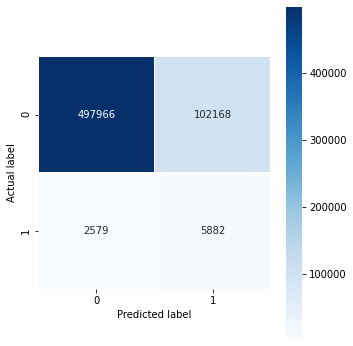

Prediction Report with features of past 1000ms
               precision    recall  f1-score   support

           0       0.99      0.84      0.91    600134
           1       0.06      0.69      0.11      8461

    accuracy                           0.84    608595
   macro avg       0.53      0.77      0.51    608595
weighted avg       0.98      0.84      0.90    608595



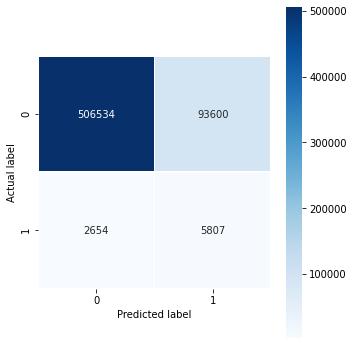

Prediction Report with features of past 1500ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    600134
           1       0.06      0.68      0.11      8461

    accuracy                           0.84    608595
   macro avg       0.53      0.76      0.51    608595
weighted avg       0.98      0.84      0.90    608595



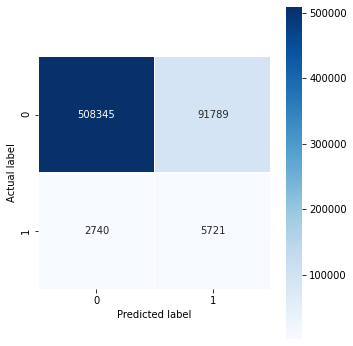

Prediction Report with features of past 2000ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.67      0.11      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.76      0.51    608595
weighted avg       0.98      0.85      0.90    608595



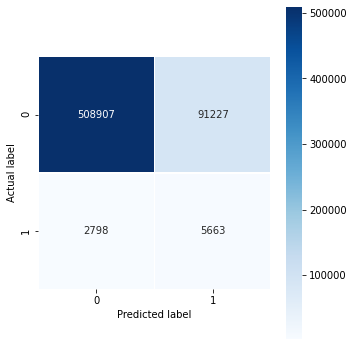

Prediction Report with features of past 2500ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.66      0.11      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.90    608595



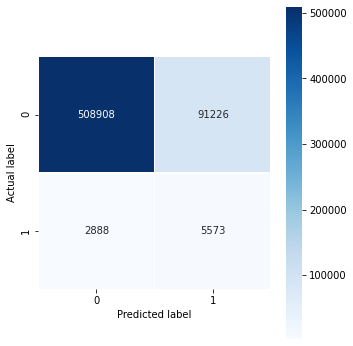

Prediction Report with features of past 3000ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.66      0.11      8461

    accuracy                           0.84    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.84      0.90    608595



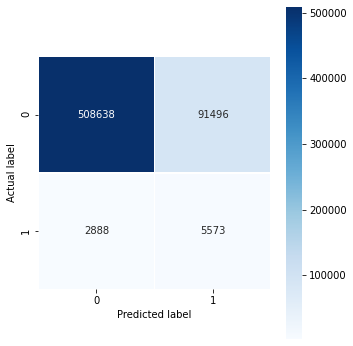

Prediction Report with features of past 3500ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.65      0.11      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.90    608595



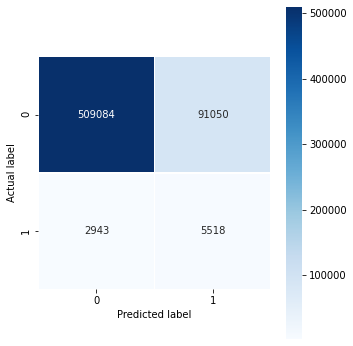

Prediction Report with features of past 4000ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.65      0.10      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.90    608595



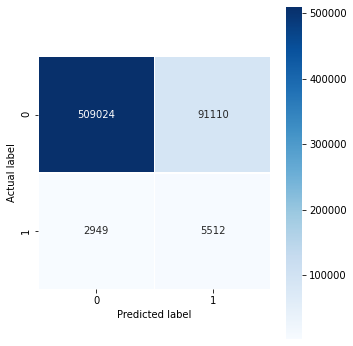

Prediction Report with features of past 4500ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.65      0.10      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.90    608595



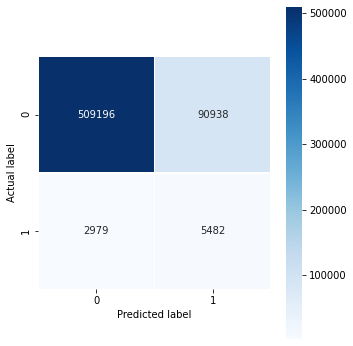

Prediction Report with features of past 5000ms
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    600134
           1       0.06      0.65      0.10      8461

    accuracy                           0.85    608595
   macro avg       0.53      0.75      0.51    608595
weighted avg       0.98      0.85      0.90    608595



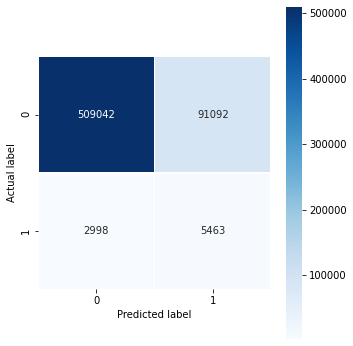

In [49]:
# this is for brt with weight
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

acc = []
precision = []                                         
recall = []
f1 = []
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    rf_new = BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0, class_weight={0:1, 1:weight})
    rf_new.fit(x_train_new, y_train_new)
    
    # output result
    y_pred = rf_new.predict(x_test_new)
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, y_pred))
    cm = confusion_matrix(y_test_new, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_test_new, y_pred, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

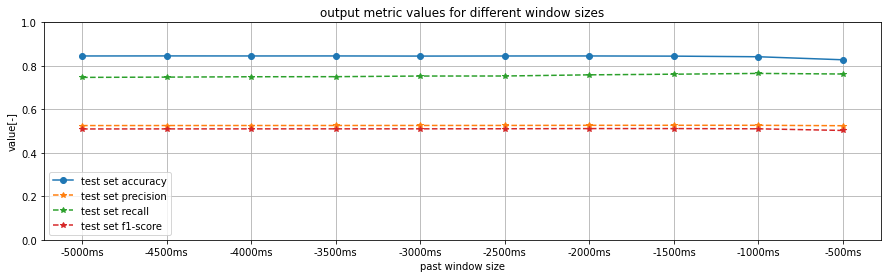

In [60]:
# no change if with less trees !!!!!!

acc_rev = list(reversed(acc))
precision_rev = list(reversed(precision))                                      
recall_rev = list(reversed(recall))
f1_rev = list(reversed(f1))

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, acc_rev, 'o-', label='test set accuracy')
plt.plot(label, precision_rev, '*--', label='test set precision')
plt.plot(label, recall_rev, '*--', label='test set recall')
plt.plot(label, f1_rev, '*--', label='test set f1-score')
plt.legend()
plt.xlabel('past window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

Prediction Report with features of past 500ms
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    600134
           1       0.05      0.76      0.09      8461

    accuracy                           0.79    608595
   macro avg       0.52      0.78      0.49    608595
weighted avg       0.98      0.79      0.87    608595



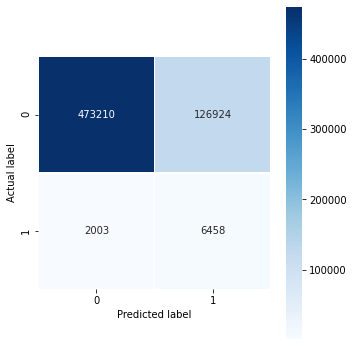

Prediction Report with features of past 1000ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.78      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.52      0.79      0.49    608595
weighted avg       0.98      0.80      0.87    608595



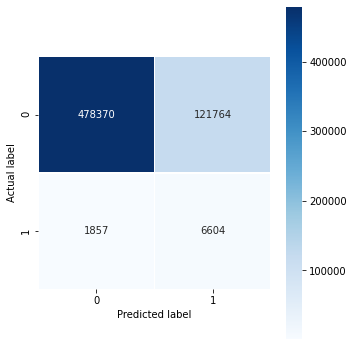

Prediction Report with features of past 1500ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.52      0.79      0.49    608595
weighted avg       0.98      0.80      0.88    608595



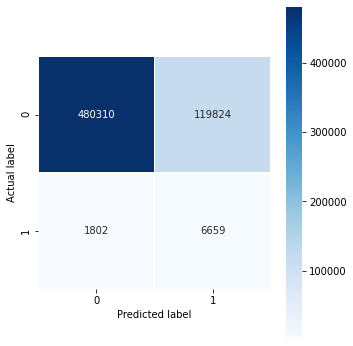

Prediction Report with features of past 2000ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.52      0.79      0.49    608595
weighted avg       0.98      0.80      0.88    608595



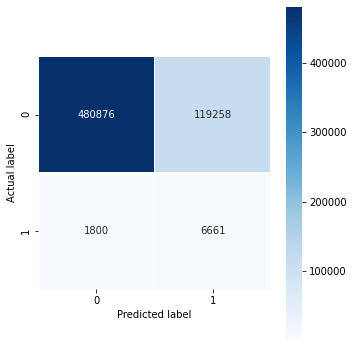

Prediction Report with features of past 2500ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.52      0.79      0.49    608595
weighted avg       0.98      0.80      0.88    608595



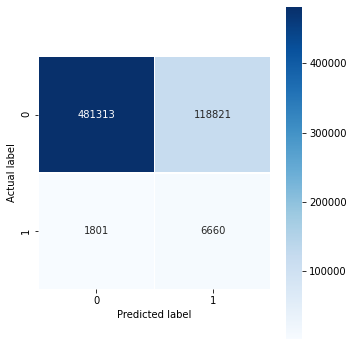

Prediction Report with features of past 3000ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.80    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.80      0.88    608595



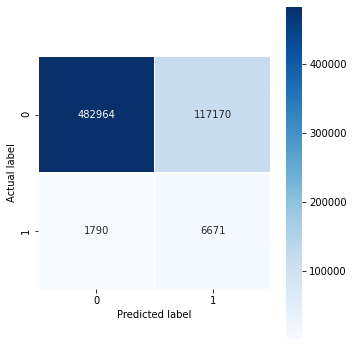

Prediction Report with features of past 3500ms
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



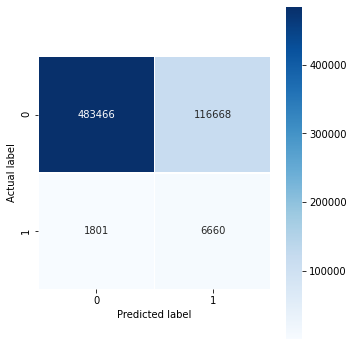

Prediction Report with features of past 4000ms
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



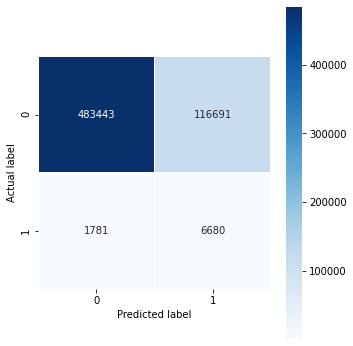

Prediction Report with features of past 4500ms
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



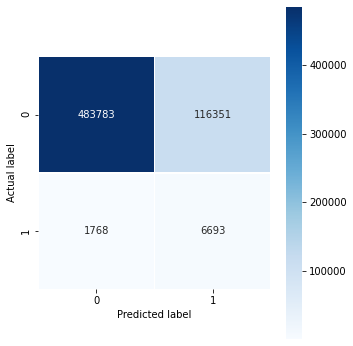

Prediction Report with features of past 5000ms
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.05      0.79      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



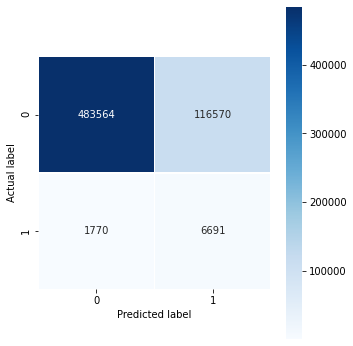

In [28]:
# this is for brt without weight
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

acc = []
precision = []                                         
recall = []
f1 = []
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    rf_new = BalancedRandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)
    rf_new.fit(x_train_new, y_train_new)
    
    # output result
    y_pred = rf_new.predict(x_test_new)
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, y_pred))
    cm = confusion_matrix(y_test_new, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_test_new, y_pred, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

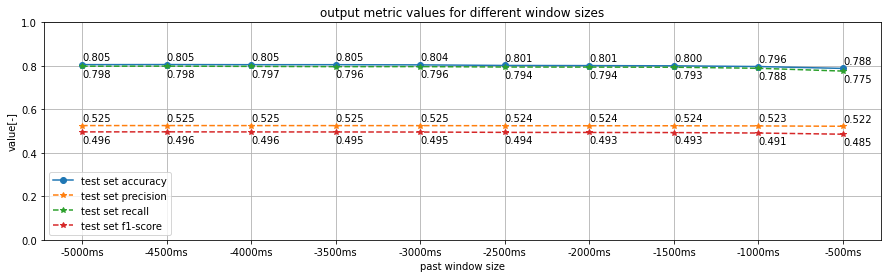

In [32]:
acc_rev = list(reversed(acc))
precision_rev = list(reversed(precision))                                      
recall_rev = list(reversed(recall))
f1_rev = list(reversed(f1))

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, acc_rev, 'o-', label='test set accuracy')
plt.plot(label, precision_rev, '*--', label='test set precision')
plt.plot(label, recall_rev, '*--', label='test set recall')
plt.plot(label, f1_rev, '*--', label='test set f1-score')

for i, txt in enumerate(acc_rev):
    plt.annotate(str(txt)[0:5], (label[i], acc_rev[i]+0.02))
for i, txt in enumerate(precision_rev):
    plt.annotate(str(txt)[0:5], (label[i], precision_rev[i]+0.02))
for i, txt in enumerate(recall_rev):
    plt.annotate(str(txt)[0:5], (label[i], recall_rev[i]-0.05))
for i, txt in enumerate(f1_rev):
    plt.annotate(str(txt)[0:5], (label[i], f1_rev[i]-0.05))
    
plt.legend()
plt.xlabel('past window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

## try smote for combination of undersampling and oversampling

In [6]:
from imblearn.over_sampling import SMOTE

In [102]:
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7 * 10)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7 * 10)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [103]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [104]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [105]:
rf_smote = RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)

In [106]:
rf_smote.fit(x_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    197448
           1       1.00      1.00      1.00     19744

    accuracy                           1.00    217192
   macro avg       1.00      1.00      1.00    217192
weighted avg       1.00      1.00      1.00    217192



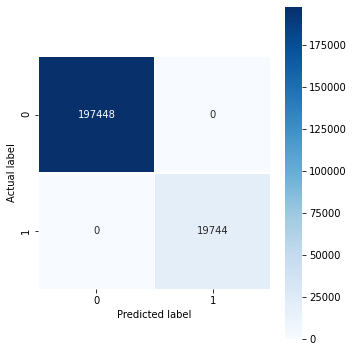

In [107]:
y_pred = rf_smote.predict(x_train)
print("Prediction Report\n", classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.06      0.47      0.10      8461

    accuracy                           0.96   1811464
   macro avg       0.53      0.72      0.54   1811464
weighted avg       0.99      0.96      0.98   1811464



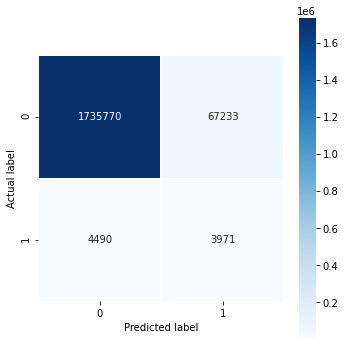

In [108]:
y_pred = rf_smote.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [63]:
# with open('models/original_random_forest_with_SMOTE_new.pickle', 'wb') as f:
#     pickle.dump(rf_smote, f)

In [7]:
# same amount of test dataset
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7 * 10)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [8]:
rf_smote = RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)

In [9]:
rf_smote.fit(x_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=400, n_jobs=48, random_state=0)

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    600134
           1       0.15      0.47      0.23      8461

    accuracy                           0.96    608595
   macro avg       0.57      0.72      0.60    608595
weighted avg       0.98      0.96      0.97    608595



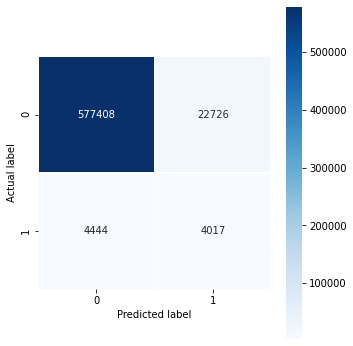

In [10]:
y_pred = rf_smote.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## deeper analysis for entire dataset

In [23]:
# final model and check out the reasoning
# rf_smote or brf_with_weight or brf_without_weight

df_loss_feature = df_loss[full_features_list]
df_no_loss_feature = df_no_loss[full_features_list]
df_loss_label = df_loss[['lossOrNot']]
df_no_loss_label = df_no_loss[['lossOrNot']]

In [26]:
# original random forest

y_pred_loss = rf_smote.predict(df_loss_feature)
y_pred_no_loss = rf_smote.predict(df_no_loss_feature)

Prediction Report for loss
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.84      0.91     28207

    accuracy                           0.84     28207
   macro avg       0.50      0.42      0.46     28207
weighted avg       1.00      0.84      0.91     28207



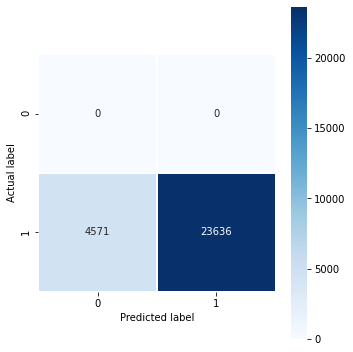

In [25]:
print("Prediction Report for loss\n", classification_report(df_loss_label, y_pred_loss))
cm = confusion_matrix(df_loss_label, y_pred_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report for no loss
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98   2000453
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97   2000453
   macro avg       0.50      0.48      0.49   2000453
weighted avg       1.00      0.97      0.98   2000453



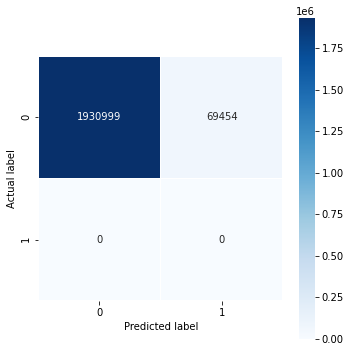

In [27]:
print("Prediction Report for no loss\n", classification_report(df_no_loss_label, y_pred_no_loss))
cm = confusion_matrix(df_no_loss_label, y_pred_no_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [39]:
# balanced random forest with weight

y_pred_loss = brf_with_weight.predict(df_loss_feature)
y_pred_no_loss = brf_with_weight.predict(df_no_loss_feature)

Prediction Report for loss
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.89      0.94     28207

    accuracy                           0.89     28207
   macro avg       0.50      0.45      0.47     28207
weighted avg       1.00      0.89      0.94     28207



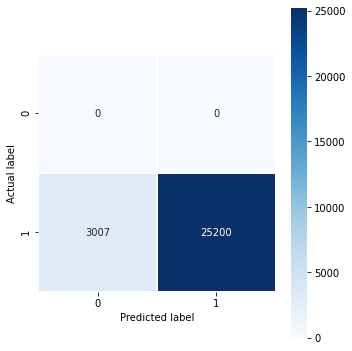

In [81]:
print("Prediction Report for loss\n", classification_report(df_loss_label, y_pred_loss))
cm = confusion_matrix(df_loss_label, y_pred_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report for no loss
               precision    recall  f1-score   support

         0.0       1.00      0.85      0.92   2000453
         1.0       0.00      0.00      0.00         0

    accuracy                           0.85   2000453
   macro avg       0.50      0.43      0.46   2000453
weighted avg       1.00      0.85      0.92   2000453



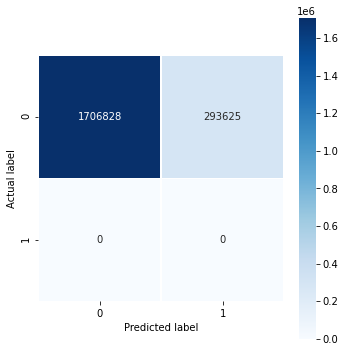

In [82]:
print("Prediction Report for no loss\n", classification_report(df_no_loss_label, y_pred_no_loss))
cm = confusion_matrix(df_no_loss_label, y_pred_no_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [41]:
# balanced random forest without weight

y_pred_loss = brf_without_weight.predict(df_loss_feature)
y_pred_no_loss = brf_without_weight.predict(df_no_loss_feature)

Prediction Report for loss
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.94      0.97     28207

    accuracy                           0.94     28207
   macro avg       0.50      0.47      0.48     28207
weighted avg       1.00      0.94      0.97     28207



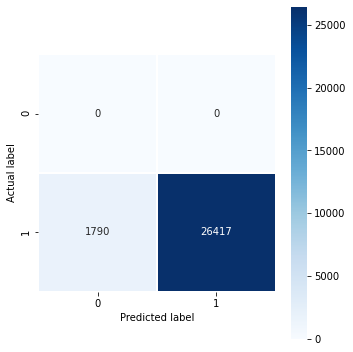

In [42]:
print("Prediction Report for loss\n", classification_report(df_loss_label, y_pred_loss))
cm = confusion_matrix(df_loss_label, y_pred_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report for no loss
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.90   2000453
         1.0       0.00      0.00      0.00         0

    accuracy                           0.81   2000453
   macro avg       0.50      0.41      0.45   2000453
weighted avg       1.00      0.81      0.90   2000453



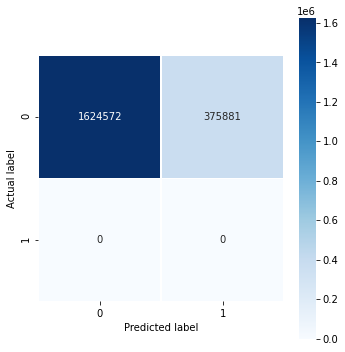

In [43]:
print("Prediction Report for no loss\n", classification_report(df_no_loss_label, y_pred_no_loss))
cm = confusion_matrix(df_no_loss_label, y_pred_no_loss)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## check characterization

In [85]:
# the following results are derived by brf_with_weight !!!!!!

df_loss_label_prediction_combine = copy.deepcopy(df_loss_label)
df_loss_label_prediction_combine['lossOrNotPred'] = y_pred_loss

df_no_loss_label_prediction_combine = copy.deepcopy(df_no_loss_label)
df_no_loss_label_prediction_combine['lossOrNotPred'] = y_pred_no_loss

In [91]:
index_loss_pred_correct = df_loss_label_prediction_combine[df_loss_label_prediction_combine['lossOrNot'] == df_loss_label_prediction_combine['lossOrNotPred']].index
index_loss_pred_incorrect = df_loss_label_prediction_combine[df_loss_label_prediction_combine['lossOrNot'] != df_loss_label_prediction_combine['lossOrNotPred']].index

index_no_loss_pred_correct = df_no_loss_label_prediction_combine[df_no_loss_label_prediction_combine['lossOrNot'] == df_no_loss_label_prediction_combine['lossOrNotPred']].index
index_no_loss_pred_incorrect = df_no_loss_label_prediction_combine[df_no_loss_label_prediction_combine['lossOrNot'] != df_no_loss_label_prediction_combine['lossOrNotPred']].index

In [100]:
df_loss_pred_correct_feature = df_loss_feature.loc[index_loss_pred_correct]
df_loss_pred_incorrect_feature = df_loss_feature.loc[index_loss_pred_incorrect]

df_no_loss_pred_correct_feature = df_no_loss_feature.loc[index_no_loss_pred_correct]
df_no_loss_pred_incorrect_feature = df_no_loss_feature.loc[index_no_loss_pred_incorrect]

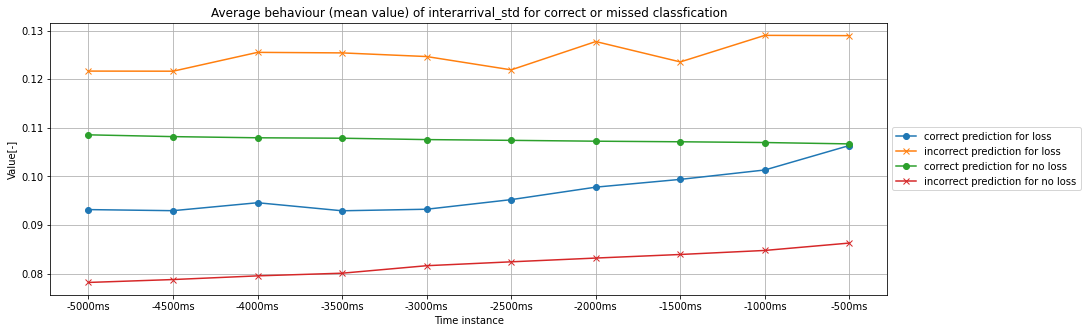

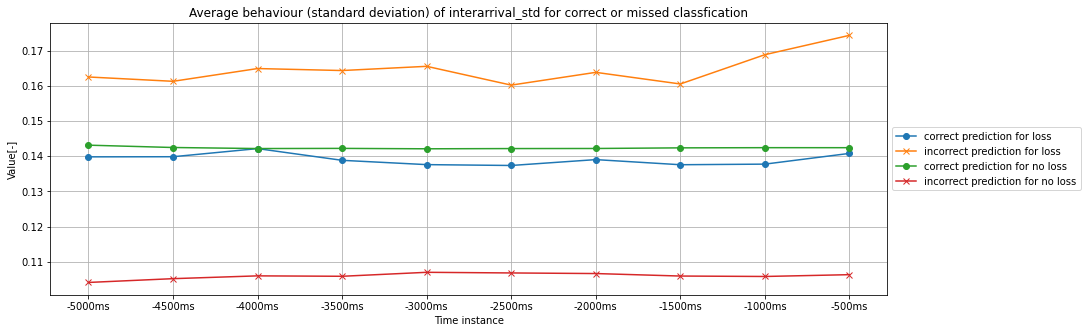

In [129]:
x_label_list = [f'-{500*i}ms' for i in range(1, 11)]
x_label_list.reverse()

for feature in selected_features_list_removing_correlation:
    avg_loss_correct_list = []
    avg_loss_incorrect_list = []
    avg_no_loss_correct_list = []
    avg_no_loss_incorrect_list = []
    std_loss_correct_list = []
    std_loss_incorrect_list = []
    std_no_loss_correct_list = []
    std_no_loss_incorrect_list = []
    
    for i in range(10,0,-1):
        col_title = f'{feature}_minus_{500*i}ms'
        
        avg_loss_correct_list.append(df_loss_pred_correct_feature[col_title].mean())
        avg_loss_incorrect_list.append(df_loss_pred_incorrect_feature[col_title].mean())
        avg_no_loss_correct_list.append(df_no_loss_pred_correct_feature[col_title].mean())
        avg_no_loss_incorrect_list.append(df_no_loss_pred_incorrect_feature[col_title].mean())
        std_loss_correct_list.append(df_loss_pred_correct_feature[col_title].std())
        std_loss_incorrect_list.append(df_loss_pred_incorrect_feature[col_title].std())
        std_no_loss_correct_list.append(df_no_loss_pred_correct_feature[col_title].std())
        std_no_loss_incorrect_list.append(df_no_loss_pred_incorrect_feature[col_title].std())
        
        avg_loss_correct_result = np.array(avg_loss_correct_list)
        avg_loss_incorrect_result = np.array(avg_loss_incorrect_list)
        avg_no_loss_correct_result = np.array(avg_no_loss_correct_list)
        avg_no_loss_incorrect_result = np.array(avg_no_loss_incorrect_list)
        std_loss_correct_result = np.array(std_loss_correct_list)
        std_loss_incorrect_result = np.array(std_loss_incorrect_list)
        std_no_loss_correct_result = np.array(std_no_loss_correct_list)
        std_no_loss_incorrect_result = np.array(std_no_loss_incorrect_list)
        
    plt.figure(figsize=(15,5))
    plt.title(f'Average behaviour (mean value) of {feature} for correct or missed classfication')
    plt.plot(x_label_list, avg_loss_correct_list, 'o-', label='correct prediction for loss')
    plt.plot(x_label_list, avg_loss_incorrect_list, 'x-', label='incorrect prediction for loss')
    plt.plot(x_label_list, avg_no_loss_correct_list, 'o-', label='correct prediction for no loss')
    plt.plot(x_label_list, avg_no_loss_incorrect_list, 'x-', label='incorrect prediction for no loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time instance')
    plt.ylabel('Value[-]')
    plt.grid()
    
    plt.figure(figsize=(15,5))
    plt.title(f'Average behaviour (standard deviation) of {feature} for correct or missed classfication')
    plt.plot(x_label_list, std_loss_correct_result, 'o-', label='correct prediction for loss')
    plt.plot(x_label_list, std_loss_incorrect_result, 'x-', label='incorrect prediction for loss')
    plt.plot(x_label_list, std_no_loss_correct_result, 'o-', label='correct prediction for no loss')
    plt.plot(x_label_list, std_no_loss_incorrect_result, 'x-', label='incorrect prediction for no loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time instance')
    plt.ylabel('Value[-]')
    plt.grid()
    
    break

In [162]:
df_loss_check_full = copy.deepcopy(df_loss)
df_loss_check_full['pred_correctOrNot'] = True
df_loss_check_full.loc[index_loss_pred_incorrect, 'pred_correctOrNot'] = False
df_loss_check_full = df_loss_check_full[['timestamp', 'group_id', 'pred_correctOrNot']]

In [187]:
num_sparse_loss_correct = 0
num_concen_loss_correct = 0
num_sparse_loss_incorrect = 0
num_concen_loss_incorrect = 0

for key, df_output in df_loss_check_full.groupby('group_id'):
    if df_output.shape[0] != 1:
        df_temp = copy.deepcopy(df_output)
        df_temp['timestamp_previous'] =  df_temp['timestamp'].shift()
        df_temp['timestamp_previous'] = pd.to_datetime(df_temp['timestamp_previous'])
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_temp['time_diff'] = (df_temp['timestamp'] - df_temp['timestamp_previous']) / np.timedelta64(1,'s')
        df_temp = df_temp[['pred_correctOrNot', 'time_diff']]
        
        if df_temp.iloc[0]['pred_correctOrNot']:
            num_sparse_loss_correct += 1
        else:
            num_sparse_loss_incorrect += 1
            
        df_temp.dropna(inplace=True)
        num_sparse_loss_correct += df_temp[(df_temp['time_diff']>5) & (df_temp['pred_correctOrNot'])]['time_diff'].count()
        num_concen_loss_correct += df_temp[(df_temp['time_diff']<=5) & (df_temp['pred_correctOrNot'])]['time_diff'].count()
        num_sparse_loss_incorrect += df_temp[(df_temp['time_diff']>5) & (~df_temp['pred_correctOrNot'])]['time_diff'].count()
        num_concen_loss_incorrect += df_temp[(df_temp['time_diff']<=5) & (~df_temp['pred_correctOrNot'])]['time_diff'].count()
    else:
        num_sparse_loss_correct += df_output[df_output['pred_correctOrNot']]['pred_correctOrNot'].count()
        num_sparse_loss_incorrect += df_output[~df_output['pred_correctOrNot']]['pred_correctOrNot'].count()

In [194]:
print('number of loss with no loss in past 5s for correct prediction: ', num_sparse_loss_correct)
print('number of loss with loss in past 5s for correct prediction: ', num_concen_loss_correct)
print('number of loss with no loss in past 5s for incorrect prediction: ', num_sparse_loss_incorrect)
print('number of loss with loss in past 5s for incorrect prediction: ', num_concen_loss_incorrect)

number of loss with no loss in past 5s for correct prediction:  9021
number of loss with loss in past 5s for correct prediction:  16179
number of loss with no loss in past 5s for incorrect prediction:  1713
number of loss with loss in past 5s for incorrect prediction:  1294


## entire dataset performance

Prediction Report for entire dataset
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98   2000453
         1.0       0.25      0.84      0.39     28207

    accuracy                           0.96   2028660
   macro avg       0.63      0.90      0.69   2028660
weighted avg       0.99      0.96      0.97   2028660



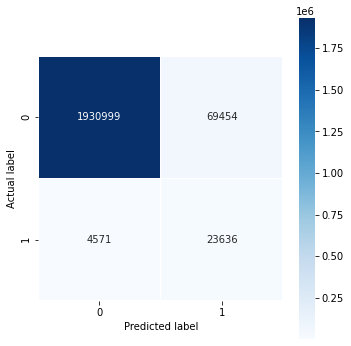

In [35]:
# original random forest

df_label_total = pd.concat([df_loss_label, df_no_loss_label])
pred_label_total = np.concatenate((y_pred_loss, y_pred_no_loss))
print("Prediction Report for entire dataset\n", classification_report(df_label_total, pred_label_total))
cm = confusion_matrix(df_label_total, pred_label_total)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report for entire dataset
               precision    recall  f1-score   support

         0.0       1.00      0.85      0.92   2000453
         1.0       0.08      0.89      0.14     28207

    accuracy                           0.85   2028660
   macro avg       0.54      0.87      0.53   2028660
weighted avg       0.99      0.85      0.91   2028660



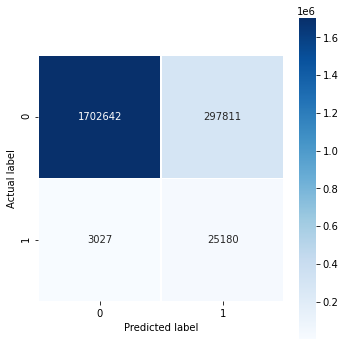

In [40]:
# balanced random forest with weight

df_label_total = pd.concat([df_loss_label, df_no_loss_label])
pred_label_total = np.concatenate((y_pred_loss, y_pred_no_loss))
print("Prediction Report for entire dataset\n", classification_report(df_label_total, pred_label_total))
cm = confusion_matrix(df_label_total, pred_label_total)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Prediction Report for entire dataset
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.90   2000453
         1.0       0.07      0.94      0.12     28207

    accuracy                           0.81   2028660
   macro avg       0.53      0.87      0.51   2028660
weighted avg       0.99      0.81      0.89   2028660



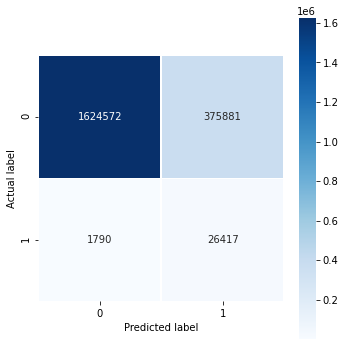

In [44]:
# balanced random forest without weight

df_label_total = pd.concat([df_loss_label, df_no_loss_label])
pred_label_total = np.concatenate((y_pred_loss, y_pred_no_loss))
print("Prediction Report for entire dataset\n", classification_report(df_label_total, pred_label_total))
cm = confusion_matrix(df_label_total, pred_label_total)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Check different window length for original random forest

Prediction Report with features of past 500ms
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1803003
           1       0.04      0.50      0.07      8461

    accuracy                           0.93   1811464
   macro avg       0.52      0.72      0.52   1811464
weighted avg       0.99      0.93      0.96   1811464



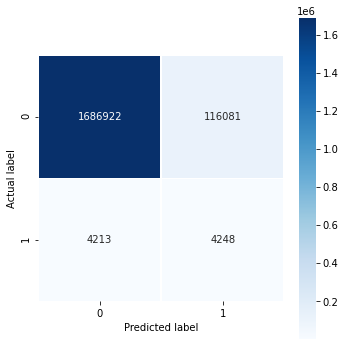

Prediction Report with features of past 1000ms
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   1803003
           1       0.04      0.50      0.08      8461

    accuracy                           0.95   1811464
   macro avg       0.52      0.72      0.53   1811464
weighted avg       0.99      0.95      0.97   1811464



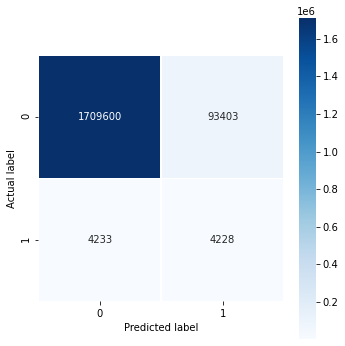

Prediction Report with features of past 1500ms
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   1803003
           1       0.05      0.50      0.09      8461

    accuracy                           0.95   1811464
   macro avg       0.52      0.72      0.53   1811464
weighted avg       0.99      0.95      0.97   1811464



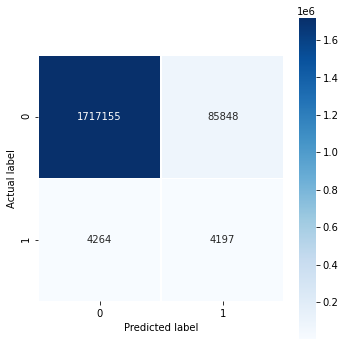

Prediction Report with features of past 2000ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.49      0.09      8461

    accuracy                           0.95   1811464
   macro avg       0.52      0.72      0.53   1811464
weighted avg       0.99      0.95      0.97   1811464



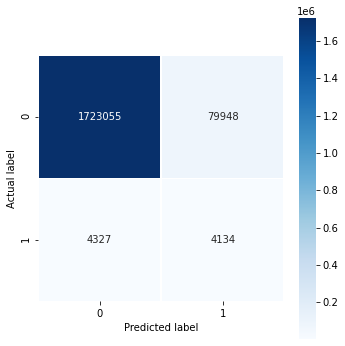

Prediction Report with features of past 2500ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.48      0.09      8461

    accuracy                           0.96   1811464
   macro avg       0.52      0.72      0.53   1811464
weighted avg       0.99      0.96      0.97   1811464



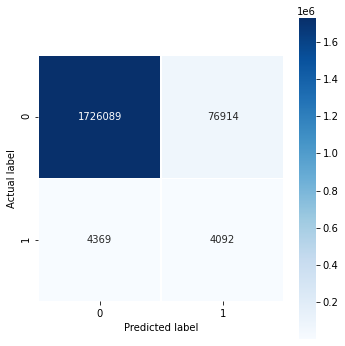

Prediction Report with features of past 3000ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.48      0.09      8461

    accuracy                           0.96   1811464
   macro avg       0.52      0.72      0.54   1811464
weighted avg       0.99      0.96      0.97   1811464



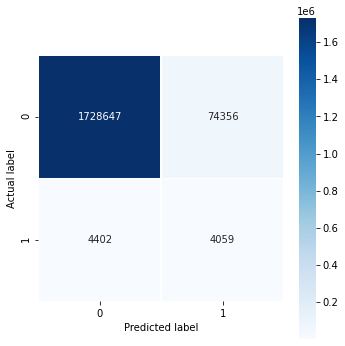

Prediction Report with features of past 3500ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.48      0.10      8461

    accuracy                           0.96   1811464
   macro avg       0.53      0.72      0.54   1811464
weighted avg       0.99      0.96      0.97   1811464



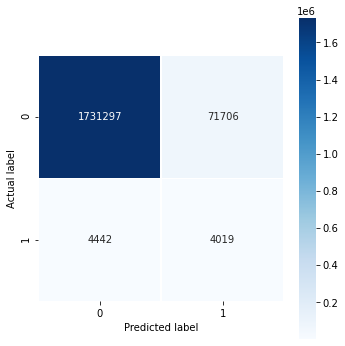

Prediction Report with features of past 4000ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.47      0.10      8461

    accuracy                           0.96   1811464
   macro avg       0.53      0.72      0.54   1811464
weighted avg       0.99      0.96      0.97   1811464



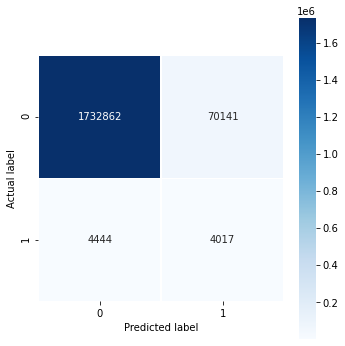

Prediction Report with features of past 4500ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.05      0.47      0.10      8461

    accuracy                           0.96   1811464
   macro avg       0.53      0.72      0.54   1811464
weighted avg       0.99      0.96      0.98   1811464



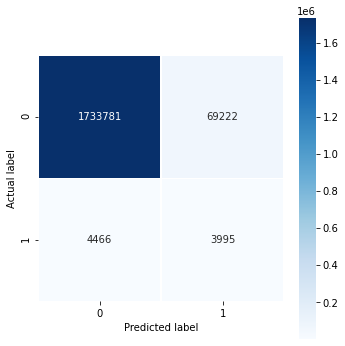

Prediction Report with features of past 5000ms
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1803003
           1       0.06      0.46      0.10      8461

    accuracy                           0.96   1811464
   macro avg       0.53      0.71      0.54   1811464
weighted avg       0.99      0.96      0.98   1811464



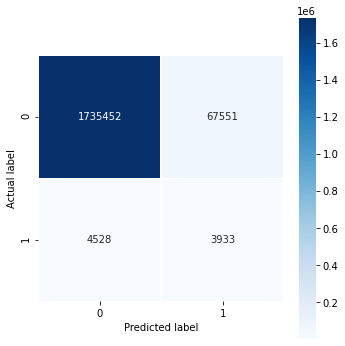

In [11]:
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

acc = []
precision = []                                         
recall = []
f1 = []
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    # oversampling with SMOTE
    smote = SMOTE()
    x_train_smote_new, y_train_smote_new = smote.fit_resample(x_train_new, y_train_new)
    
    rf_new = RandomForestClassifier(n_estimators=200, n_jobs=48, random_state=33)
    rf_new.fit(x_train_smote_new, y_train_smote_new)
    
    # output result
    y_pred = rf_new.predict(x_test_new)
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, y_pred))
    cm = confusion_matrix(y_test_new, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_test_new, y_pred, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

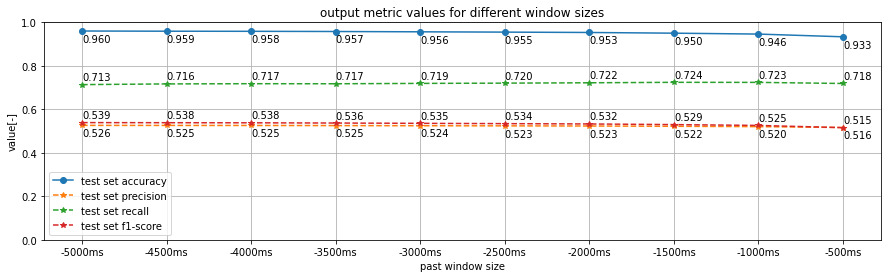

In [25]:
acc_rev = list(reversed(acc))
precision_rev = list(reversed(precision))                                      
recall_rev = list(reversed(recall))
f1_rev = list(reversed(f1))

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, acc_rev, 'o-', label='test set accuracy')
plt.plot(label, precision_rev, '*--', label='test set precision')
plt.plot(label, recall_rev, '*--', label='test set recall')
plt.plot(label, f1_rev, '*--', label='test set f1-score')

for i, txt in enumerate(acc_rev):
    plt.annotate(str(txt)[0:5], (label[i], acc_rev[i]-0.05))
for i, txt in enumerate(precision_rev):
    plt.annotate(str(txt)[0:5], (label[i], precision_rev[i]-0.05))
for i, txt in enumerate(recall_rev):
    plt.annotate(str(txt)[0:5], (label[i], recall_rev[i]+0.02))
for i, txt in enumerate(f1_rev):
    plt.annotate(str(txt)[0:5], (label[i], f1_rev[i]+0.02))
    
plt.legend()
plt.xlabel('past window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

## Model tuning for balanced random forest without weight (random search)

1. n_estimators: number of trees in the foreset 
2. max_features: max number of features considered for splitting a node
3. max_depth: max number of levels in each decision tree
4. min_samples_split: min number of data points placed in a node before the node is split
5. min_samples_leaf: min number of data points allowed in a leaf node
6. bootstrap: method for sampling data points (with or without replacement)

In [8]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_features = ['auto', 'log2', None]

max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

min_samples_split = [2, 4, 6, 8, 10]

min_samples_leaf = [1, 2, 4, 6]

bootstrap = [True, False]

random_grid_dict = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid_dict)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2', None],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [50]:
brf = BalancedRandomForestClassifier()

brf_random_search = RandomizedSearchCV(
    estimator = brf, 
    param_distributions = random_grid_dict, 
    n_iter = 100, 
    cv = 3,
    random_state=33, 
    n_jobs = 48
)

brf_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=BalancedRandomForestClassifier(), n_jobs=48,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=33)

In [51]:
brf_random_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [52]:
best_brf_model = brf_random_search.best_estimator_

In [47]:
# best_brf_model = BalancedRandomForestClassifier(bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=4, n_estimators=600, n_jobs=48)

In [48]:
# best_brf_model.fit(x_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, max_depth=90,
                               min_samples_leaf=2, min_samples_split=4,
                               n_estimators=600, n_jobs=48)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.06      0.80      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



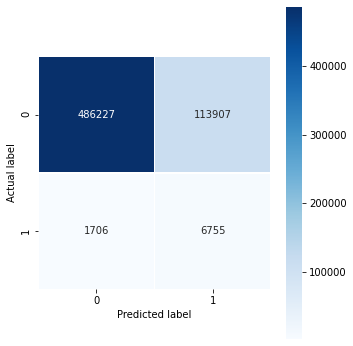

In [53]:
y_pred = best_brf_model.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [54]:
# with open('models/balanced_random_forest_without_weight_final.pickle', 'wb') as f:
#     pickle.dump(best_brf_model, f)

In [9]:
# optimize the model in terms of recall

brf_tuning = BalancedRandomForestClassifier(n_jobs = 48)

brf_random_search_recall = RandomizedSearchCV(
    estimator = brf_tuning, 
    param_distributions = random_grid_dict, 
    n_iter = 100, 
    cv = 3,
    random_state = 66, 
    scoring = 'recall_macro'
)

brf_random_search_recall.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=BalancedRandomForestClassifier(n_jobs=48),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=66, scoring='recall_macro')

In [10]:
brf_random_search_recall.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89    600134
           1       0.06      0.80      0.10      8461

    accuracy                           0.81    608595
   macro avg       0.53      0.80      0.50    608595
weighted avg       0.98      0.81      0.88    608595



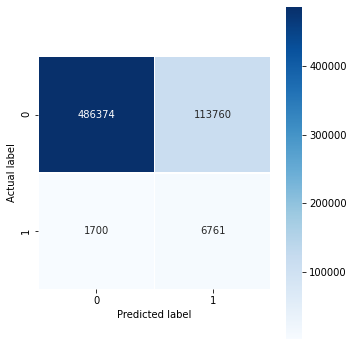

In [11]:
# the result doesn't change 

y_pred = brf_random_search_recall.best_estimator_.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()